In [2]:
import os
import mne

raw_data = []
raw_dir = os.path.join('..', 'raw')

n = 1
while True:
    fname = os.path.join(raw_dir, f'resting_state{n}.set')
    if not os.path.exists(fname):
        print(f'No file found: {fname} — stopping (last checked {n}).')
        break

    print(f'Processing: {fname}')
    raw = mne.io.read_raw_eeglab(fname, preload=True)

    raw_data.append(raw)
    n += 1

raw_data

Processing: ..\raw\resting_state1.set


C:\Users\JINQI\AppData\Local\Temp\ipykernel_36116\1226793667.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(fname, preload=True)


Processing: ..\raw\resting_state2.set


C:\Users\JINQI\AppData\Local\Temp\ipykernel_36116\1226793667.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(fname, preload=True)


Processing: ..\raw\resting_state3.set
No file found: ..\raw\resting_state4.set — stopping (last checked 4).


C:\Users\JINQI\AppData\Local\Temp\ipykernel_36116\1226793667.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(fname, preload=True)


[<RawEEGLAB | resting_state1.set, 129 x 160242 (320.5 s), ~157.9 MiB, data loaded>,
 <RawEEGLAB | resting_state2.set, 129 x 158542 (317.1 s), ~156.2 MiB, data loaded>,
 <RawEEGLAB | resting_state3.set, 129 x 176967 (353.9 s), ~174.3 MiB, data loaded>]

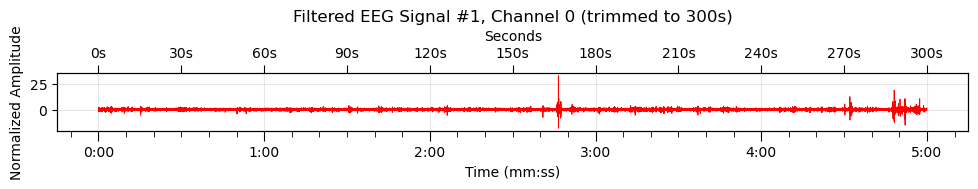

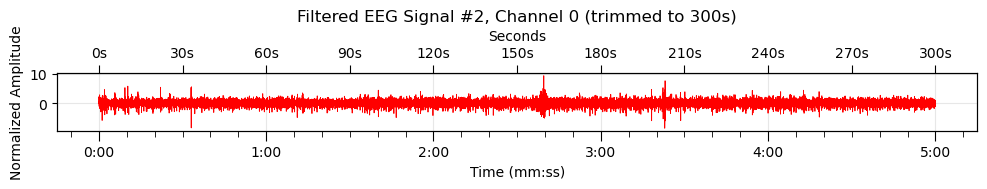

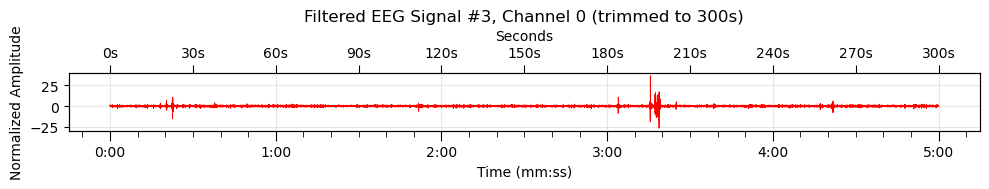

In [ ]:
from biosppy.signals import eeg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import zscore

chan_name = 0  # channel index
max_duration_seconds = 5 * 60  # 5 minutes

# fn to format time
def format_mmss(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f"{minutes}:{seconds:02d}"

for n, raw in enumerate(raw_data, start=1):
    data = raw.get_data(picks=[chan_name])[0]
    sfreq = raw.info['sfreq']

    out = eeg.eeg(signal=data, sampling_rate=sfreq, show=False)

    # Trim to first 5 minutes
    max_samples = int(max_duration_seconds * sfreq)
    total_samples = len(out['filtered'])
    end_idx = min(total_samples, max_samples)

    filtered = zscore(out['filtered'][:end_idx])
    ts = out['ts'][:end_idx]

    # reduced-height figure so more plots fit vertically
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.plot(ts, filtered, 'r-', linewidth=0.6)
    ax.set_title(f"Filtered EEG Signal #{n}, Channel {chan_name} (trimmed to {end_idx/sfreq:.0f}s)")
    ax.set_xlabel("Time (mm:ss)")
    ax.set_ylabel("Normalized Amplitude")
    ax.grid(True, alpha=0.3)

    # Bottom axis: minute ticks (major) and minor ticks (seconds)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_mmss))
    ax.tick_params(axis='x', which='major', length=7)
    ax.tick_params(axis='x', which='minor', length=4)

    # Top axis: seconds ticks with 'Xs' labels for clarity
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    # show seconds every 30s for readability (adjust as needed)
    ax_top.xaxis.set_major_locator(ticker.MultipleLocator(30))
    ax_top.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x)}s"))
    ax_top.tick_params(axis='x', which='major', length=6)
    ax_top.set_xlabel('Seconds')

    plt.tight_layout()
    plt.show()